# Gaussian Process Regression with Newly Proposed API

In [1]:
from matplotlib import pyplot as plt

import math
import torch

# Numerics and scientific computing
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

## Data

In [2]:
num_traindata = 1000
train_x = torch.linspace(0, 1, num_traindata)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.02)

test_x = torch.linspace(0, 1, num_traindata)

## Model

In [3]:
from gpytorch import models, means, kernels, distributions, likelihoods

model = models.zoo.CholeskyGP(
    mean=means.ZeroMean(),
    kernel=kernels.ScaleKernel(kernels.MaternKernel()),
    train_inputs=train_x,
    train_targets=train_y,
)
model

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


CholeskyGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (approximation_strategy): Cholesky()
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [4]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0., requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.]], requires_grad=True))]

## Training

In [5]:
from gpytorch import mlls

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()

    # Training error
    f_pred = model(train_x)
    loss = -mll(f_pred, train_y)

    with torch.no_grad():
        # Test error
        model.eval()
        f_test_pred = model(test_x)
        model.train()

    # Backward pass
    loss.backward()

    # Update hyperparameters
    optimizer.step()

    print(
        f"Iteration: {(i + 1):3d}/{training_iter:d} \t Loss: {loss.item():.3f}\t"
        f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f}\t"
        f"noise: {model.likelihood.noise.item():.3f}\t"
    )

Iteration:   1/100 	 Loss: 0.781	lengthscale: 0.644	noise: 0.644	
Iteration:   2/100 	 Loss: 0.744	lengthscale: 0.599	noise: 0.598	
Iteration:   3/100 	 Loss: 0.702	lengthscale: 0.556	noise: 0.554	
Iteration:   4/100 	 Loss: 0.662	lengthscale: 0.518	noise: 0.513	
Iteration:   5/100 	 Loss: 0.625	lengthscale: 0.484	noise: 0.474	
Iteration:   6/100 	 Loss: 0.587	lengthscale: 0.455	noise: 0.437	
Iteration:   7/100 	 Loss: 0.546	lengthscale: 0.430	noise: 0.403	
Iteration:   8/100 	 Loss: 0.508	lengthscale: 0.408	noise: 0.370	
Iteration:   9/100 	 Loss: 0.469	lengthscale: 0.389	noise: 0.340	
Iteration:  10/100 	 Loss: 0.433	lengthscale: 0.373	noise: 0.312	
Iteration:  11/100 	 Loss: 0.389	lengthscale: 0.360	noise: 0.286	
Iteration:  12/100 	 Loss: 0.351	lengthscale: 0.351	noise: 0.262	
Iteration:  13/100 	 Loss: 0.305	lengthscale: 0.345	noise: 0.239	
Iteration:  14/100 	 Loss: 0.274	lengthscale: 0.342	noise: 0.218	
Iteration:  15/100 	 Loss: 0.227	lengthscale: 0.341	noise: 0.199	
Iteration:

## Prediction

In [6]:
model.eval()

with torch.no_grad():
    test_x = torch.linspace(-0.2, 1.2, 1000)
    f_pred = model(test_x)
    y_pred = model.likelihood(f_pred)

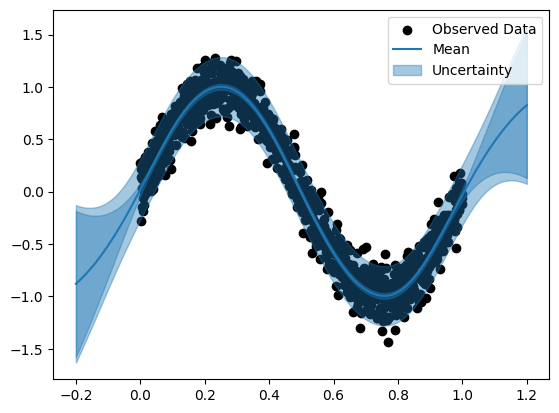

In [7]:
with torch.no_grad():
    fig, ax = plt.subplots(1, 1)

    f_pred_lower, f_pred_upper = f_pred.confidence_region()
    y_pred_lower, y_pred_upper = y_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy(), color="black")
    ax.plot(test_x.numpy(), y_pred.mean.numpy(), color="C0")
    ax.fill_between(test_x.numpy(), y_pred_lower, y_pred_upper, alpha=0.4, color="C0")
    ax.fill_between(test_x.numpy(), f_pred_lower, f_pred_upper, alpha=0.4, color="C0")
    ax.legend(["Observed Data", "Mean", "Uncertainty"])

In [8]:
list(model.named_buffers())

[('likelihood.noise_covar.raw_noise_constraint.lower_bound',
  tensor(1.0000e-04)),
 ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)),
 ('approximation_strategy.prior_predictive_train_mean',
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

In [9]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-3.9162], requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(1.4939, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.2969]], requires_grad=True))]

In [10]:
list(model.named_buffers())

[('likelihood.noise_covar.raw_noise_constraint.lower_bound',
  tensor(1.0000e-04)),
 ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)),
 ('approximation_strategy.prior_predictive_train_mean',
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0